# Risk Management Dashboard - Stress Testing

This notebook implements stress testing methodologies for the risk management dashboard. We'll use both historical and synthetic scenarios to assess portfolio performance under extreme conditions.

## Why Stress Testing?

While Value-at-Risk (VaR) provides a statistical measure of risk under normal market conditions, stress testing helps us understand portfolio behavior in extreme but plausible scenarios. Key benefits include:

1. **Beyond Statistical Assumptions**: Evaluates risks that may not be captured by standard statistical models
2. **Forward-Looking Perspective**: Allows assessment of emerging risks and hypothetical scenarios
3. **Tail Risk Assessment**: Quantifies losses in severe market disruptions beyond VaR confidence levels
4. **Targeted Analysis**: Can focus on specific vulnerabilities or risk factors

## Stress Testing Approaches Covered

1. **Historical Scenario Analysis**: Replaying historical crisis periods
2. **Synthetic Scenario Design**: Creating hypothetical extreme scenarios
3. **Macroeconomic Factor Integration**: Incorporating economic variables into stress tests
4. **Liquidity Stress Testing**: Simulating market liquidity disruptions
5. **Multi-Factor Scenario Analysis**: Combining multiple risk factors

## Overview of Steps

1. Load processed portfolio and asset returns
2. Implement historical scenario analysis
3. Create synthetic stress scenarios
4. Integrate macroeconomic factors
5. Analyze liquidity stress
6. Combine and compare scenarios
7. Visualize stress test results
8. Save stress test results for the dashboard

In [1]:
# Import standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

# Configure plot styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Set up project paths
PROJECT_ROOT = Path().resolve().parents[0]
CONFIG_DIR = PROJECT_ROOT / "configs"
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

# Make sure results directory exists
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard
Processed data directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed
Results directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results


## 1. Import Stress Testing Modules and Load Configuration

In [3]:
# Add the project root to the path
import sys
sys.path.append(str(PROJECT_ROOT))

# Import stress testing functions
from src.stress_testing.scenarios import (
    historical_scenario,
    synthetic_scenario,
    macro_shock_scenario,
    liquidity_stress_scenario,
    multiple_scenario_analysis,
    run_predefined_scenarios
)

from src.stress_testing.macro_integration import (
    estimate_factor_model,
    simulate_macro_scenario,
    create_macro_stress_scenarios,
    run_macro_scenario_analysis,
    visualize_macro_scenarios
)

# Import VaR functions for comparison
from src.models.historical_var import (
    calculate_historical_var,
    calculate_conditional_var
)

# Import data retrieval functions
from src.data.retrieve_data import load_crisis_periods

# Load model configuration
with open(CONFIG_DIR / "model_config.json", 'r') as f:
    model_config = json.load(f)

# Display stress testing configuration
stress_config = model_config.get('stress_testing', {})
print("Stress Testing Configuration:")
for key, value in stress_config.items():
    print(f"  - {key}: {value}")

Stress Testing Configuration:
  - historical_scenarios: [{'name': 'Global Financial Crisis', 'start_date': '2008-09-01', 'end_date': '2009-03-31'}, {'name': 'COVID-19 Crash', 'start_date': '2020-02-20', 'end_date': '2020-03-23'}, {'name': '2022 Rate Hikes', 'start_date': '2022-01-01', 'end_date': '2022-12-31'}]
  - synthetic_scenarios: [{'name': 'Severe Rate Hike', 'rate_shock': 2.0, 'equity_drop': 0.2}, {'name': 'Stagflation', 'rate_shock': 1.5, 'equity_drop': 0.15, 'inflation_shock': 5.0}, {'name': 'Liquidity Crisis', 'credit_spread_widening': 3.0, 'equity_drop': 0.25}]


## 2. Load Processed Returns Data

In [4]:
# Load portfolio returns
portfolio_file = PROCESSED_DIR / "portfolio_returns.csv"

if portfolio_file.exists():
    portfolio_returns = pd.read_csv(portfolio_file, index_col=0, parse_dates=True)
    
    # Convert to Series if it's a DataFrame with one column
    if isinstance(portfolio_returns, pd.DataFrame) and portfolio_returns.shape[1] == 1:
        portfolio_returns = portfolio_returns.iloc[:, 0]
    
    print(f"Loaded portfolio returns from {portfolio_file}")
    print(f"Portfolio returns shape: {portfolio_returns.shape}")
    print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")
else:
    print(f"Portfolio returns file not found at {portfolio_file}")
    print("Please run the data cleaning notebook (02_data_cleaning.ipynb) first.")
    portfolio_returns = None

# Load individual asset returns (if available)
market_returns_file = PROCESSED_DIR / "market_returns.csv"

if market_returns_file.exists():
    market_returns = pd.read_csv(market_returns_file, index_col=0, parse_dates=True)
    print(f"Loaded market returns from {market_returns_file}")
    print(f"Market returns shape: {market_returns.shape}")
    
    # Display available assets
    if isinstance(market_returns.columns, pd.MultiIndex):
        assets = market_returns.columns.levels[1]
        print(f"Available assets: {list(assets)}")
    else:
        print(f"Available assets: {list(market_returns.columns)}")
else:
    print(f"Market returns file not found at {market_returns_file}")
    print("Please run the data cleaning notebook (02_data_cleaning.ipynb) first.")
    market_returns = None

# Load macroeconomic data (if available)
macro_file = PROCESSED_DIR / "macro_data.csv"

if macro_file.exists():
    macro_data = pd.read_csv(macro_file, index_col=0, parse_dates=True)
    print(f"\nLoaded macro data from {macro_file}")
    print(f"Macro data shape: {macro_data.shape}")
    print(f"Available indicators: {list(macro_data.columns)}")
else:
    print("\nMacroeconomic data file not found. Some stress tests may not be available.")
    macro_data = None

Loaded portfolio returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/portfolio_returns.csv
Portfolio returns shape: (1988,)
Date range: 2014-01-03 00:00:00 to 2022-01-21 00:00:00
Loaded market returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/market_returns.csv
Market returns shape: (1988, 2)
Available assets: ['SPX', 'US10YT=RR']

Loaded macro data from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/macro_data.csv
Macro data shape: (1989, 3)
Available indicators: ['TEDRATE', 'VIXCLS', 'DFF']


## 3. Set Investment Value and Load Crisis Periods

In [5]:
# Set the investment value
investment_value = 1000000  # $1 million
print(f"Investment value: ${investment_value:,}")

# Load crisis periods
crisis_periods = load_crisis_periods()
print("\nHistorical Crisis Periods:")
display(crisis_periods)

Investment value: $1,000,000

Historical Crisis Periods:


,name,start_date,end_date,description,duration_days
0,Global Financial Crisis,2008-09-01,2009-03-31,Severe economic downturn following the collaps...,211
1,Dot-com Bubble,2000-03-10,2002-10-09,Collapse of technology stocks following excess...,944
2,COVID-19 Crash,2020-02-20,2020-03-23,Rapid market decline due to the COVID-19 pandemic,32
3,2013 Taper Tantrum,2013-05-22,2013-09-05,Market reaction to Fed announcement of QE tape...,106
4,2018 Q4 Selloff,2018-10-01,2018-12-24,Rapid market decline due to Fed rate hikes and...,84
5,2022 Rate Hikes,2022-01-01,2022-12-31,Market decline due to aggressive Fed rate hike...,364


## 4. Historical Scenario Analysis

In this section, we'll analyze how our portfolio would have performed during historical crisis periods.

No returns data found for period 2008-09-01 00:00:00 to 2009-03-31 00:00:00


Analyzing Global Financial Crisis: 2008-09-01 00:00:00 to 2009-03-31 00:00:00 (211 days)
Crisis returns shape: (0, 2)

Global Financial Crisis Asset Performance:


,Asset,Mean Return,Std Dev,Min Return,Max Return,Cumulative Return
0,SPX,NaN,NaN,NaN,NaN,0.0
1,US10YT=RR,NaN,NaN,NaN,NaN,0.0


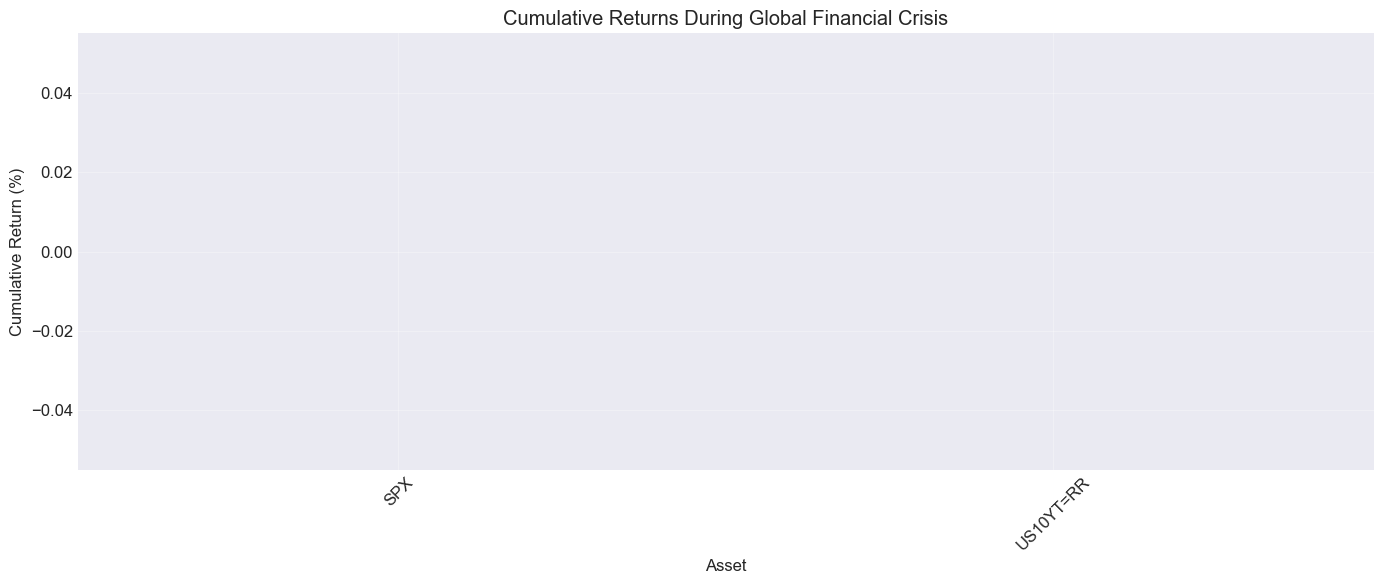

In [6]:
# Analyze historical crisis periods
if market_returns is not None:
    # Select a major crisis for analysis (e.g., Global Financial Crisis)
    crisis_name = "Global Financial Crisis"
    
    # Extract crisis period from loaded data
    crisis_info = crisis_periods[crisis_periods['name'] == crisis_name].iloc[0]
    print(f"Analyzing {crisis_name}: {crisis_info['start_date']} to {crisis_info['end_date']} ({crisis_info['duration_days']} days)")
    
    # Extract returns during the crisis period
    crisis_returns = historical_scenario(
        returns=market_returns,
        crisis_period=crisis_name
    )
    
    print(f"Crisis returns shape: {crisis_returns.shape}")
    
    # Calculate basic statistics for the crisis period
    if isinstance(market_returns.columns, pd.MultiIndex):
        # For multi-level columns, select a price column (e.g., TRDPRC_1 or Close)
        price_col = None
        for col in ['TRDPRC_1', 'Close', 'Adj Close']:
            if col in market_returns.columns.levels[0]:
                price_col = col
                break
        
        if price_col is not None:
            # Calculate statistics for each asset
            crisis_stats = pd.DataFrame({
                'Asset': crisis_returns[price_col].columns,
                'Mean Return': crisis_returns[price_col].mean().values,
                'Std Dev': crisis_returns[price_col].std().values,
                'Min Return': crisis_returns[price_col].min().values,
                'Max Return': crisis_returns[price_col].max().values,
                'Cumulative Return': ((1 + crisis_returns[price_col]).prod() - 1).values
            })
        else:
            print("Could not identify price column")
            crisis_stats = None
    else:
        # For regular DataFrame
        crisis_stats = pd.DataFrame({
            'Asset': crisis_returns.columns,
            'Mean Return': crisis_returns.mean().values,
            'Std Dev': crisis_returns.std().values,
            'Min Return': crisis_returns.min().values,
            'Max Return': crisis_returns.max().values,
            'Cumulative Return': ((1 + crisis_returns).prod() - 1).values
        })
    
    # Sort by cumulative return
    if crisis_stats is not None:
        crisis_stats = crisis_stats.sort_values(by='Cumulative Return')
        
        # Display statistics
        print(f"\n{crisis_name} Asset Performance:")
        display(crisis_stats)
        
        # Plot cumulative returns during crisis
        plt.figure(figsize=(14, 6))
        plt.bar(crisis_stats['Asset'], crisis_stats['Cumulative Return'] * 100, color='darkred')
        plt.title(f"Cumulative Returns During {crisis_name}")
        plt.xlabel("Asset")
        plt.ylabel("Cumulative Return (%)")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [7]:
# Calculate VaR using crisis period data
if market_returns is not None and 'crisis_returns' in locals() and not crisis_returns.empty:
    # Select price column if needed
    if isinstance(crisis_returns.columns, pd.MultiIndex) and 'price_col' in locals() and price_col is not None:
        crisis_returns_data = crisis_returns[price_col]
    else:
        crisis_returns_data = crisis_returns
    
    # Calculate portfolio returns during the crisis
    if isinstance(portfolio_returns, pd.Series):
        # If portfolio returns are already calculated, extract for the crisis period
        portfolio_crisis = portfolio_returns.loc[crisis_returns_data.index]
    else:
        # If we need to calculate portfolio returns (equal weights)
        weights = np.ones(len(crisis_returns_data.columns)) / len(crisis_returns_data.columns)
        portfolio_crisis = crisis_returns_data.dot(weights)
    
    # Calculate crisis period statistics
    cumulative_return = (1 + portfolio_crisis).prod() - 1
    max_drawdown = (portfolio_crisis + 1).cumprod().div((portfolio_crisis + 1).cumprod().cummax()).min() - 1
    
    print(f"\nPortfolio Performance During {crisis_name}:")
    print(f"  - Mean daily return: {portfolio_crisis.mean():.2%}")
    print(f"  - Daily volatility: {portfolio_crisis.std():.2%}")
    print(f"  - Minimum daily return: {portfolio_crisis.min():.2%}")
    print(f"  - Maximum daily return: {portfolio_crisis.max():.2%}")
    print(f"  - Cumulative return: {cumulative_return:.2%}")
    print(f"  - Maximum drawdown: {max_drawdown:.2%}")
    
    # Calculate VaR using crisis period returns
    confidence_level = 0.95
    
    crisis_var = calculate_historical_var(
        returns=portfolio_crisis,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    crisis_es = calculate_conditional_var(
        returns=portfolio_crisis,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    # Calculate normal period VaR (from full sample)
    normal_var = calculate_historical_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    normal_es = calculate_conditional_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    print(f"\nRisk Metrics Comparison ({confidence_level*100}% confidence):")
    print(f"  - Normal Period VaR: ${normal_var:,.2f} ({normal_var/investment_value:.2%})")
    print(f"  - Crisis Period VaR: ${crisis_var:,.2f} ({crisis_var/investment_value:.2%})")
    print(f"  - VaR Increase: {(crisis_var - normal_var)/normal_var:.2%}")
    print(f"  - Normal Period ES: ${normal_es:,.2f} ({normal_es/investment_value:.2%})")
    print(f"  - Crisis Period ES: ${crisis_es:,.2f} ({crisis_es/investment_value:.2%})")
    print(f"  - ES Increase: {(crisis_es - normal_es)/normal_es:.2%}")
    
    # Plot portfolio returns during crisis
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_crisis.index, portfolio_crisis.cumsum() * 100, 'darkred')
    plt.title(f"Cumulative Portfolio Returns During {crisis_name}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 5. Compare Multiple Historical Scenarios

Let's compare how the portfolio would have performed across different historical crisis periods.

Running historical scenario analysis...


No returns data found for period 2008-09-01 00:00:00 to 2009-03-31 00:00:00
No returns data found for period 2000-03-10 00:00:00 to 2002-10-09 00:00:00
No returns data found for period 2013-05-22 00:00:00 to 2013-09-05 00:00:00


Skipping Global Financial Crisis: No returns data available for this period
Skipping Dot-com Bubble: No returns data available for this period
Skipping 2013 Taper Tantrum: No returns data available for this period
Historical Scenario Analysis Results (95.0% confidence):


,scenario,var_value,es_value,var_pct,es_pct,max_loss,max_loss_pct
0,Baseline,20927.9202,32051.3488,2.0928,3.2051,215710.3155,21.5710
1,COVID-19 Crash,48061.7997,48858.3782,4.8062,4.8858,48858.3782,4.8858
2,2018 Q4 Selloff,22835.2307,25712.5375,2.2835,2.5713,28935.9550,2.8936
3,2022 Rate Hikes,19887.3561,30679.1650,1.9887,3.0679,30679.1650,3.0679


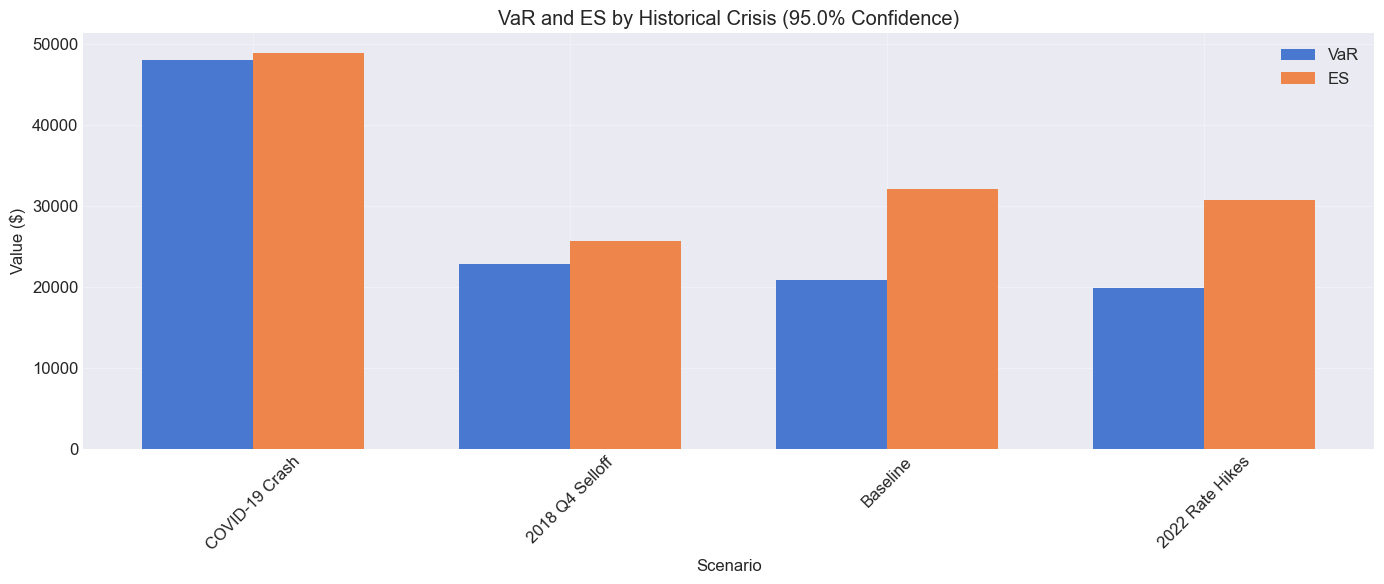

In [8]:
# Compare portfolio performance across historical crisis periods
if market_returns is not None and portfolio_returns is not None:
    # Set confidence level
    confidence_level = 0.95
    
    # Create scenarios dictionary for historical crises
    historical_scenarios = {}
    
    for _, crisis in crisis_periods.iterrows():
        historical_scenarios[crisis['name']] = {
            'type': 'historical',
            'crisis_period': crisis['name']
        }
    
    # Run historical scenario analysis
    print("Running historical scenario analysis...")
    historical_results = multiple_scenario_analysis(
        returns=portfolio_returns if isinstance(portfolio_returns, pd.DataFrame) else pd.DataFrame(portfolio_returns),
        scenarios=historical_scenarios,
        investment_value=investment_value,
        confidence_level=confidence_level
    )
    
    # Display results
    print(f"Historical Scenario Analysis Results ({confidence_level*100}% confidence):")
    display(historical_results)
    
    # Plot VaR and ES by scenario
    plt.figure(figsize=(14, 6))
    
    # Sort by VaR
    sorted_results = historical_results.sort_values(by='var_value', ascending=False)
    
    # Create bar chart
    x = np.arange(len(sorted_results))
    width = 0.35
    
    plt.bar(x - width/2, sorted_results['var_value'], width, label='VaR')
    plt.bar(x + width/2, sorted_results['es_value'], width, label='ES')
    
    plt.title(f"VaR and ES by Historical Crisis ({confidence_level*100}% Confidence)")
    plt.xlabel("Scenario")
    plt.ylabel("Value ($)")
    plt.xticks(x, sorted_results['scenario'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Synthetic Scenario Analysis

Now let's create and analyze synthetic stress scenarios.

Running synthetic scenario analysis...


Asset SPX not found in returns data
Asset US10YT=RR not found in returns data
Asset SPX not found in returns data
Asset US10YT=RR not found in returns data


Synthetic Scenario Analysis Results (95.0% confidence):


,scenario,var_value,es_value,var_pct,es_pct,max_loss,max_loss_pct
0,Baseline,20927.9202,32051.3488,2.0928,3.2051,215710.3155,21.5710
1,Severe Market Crash,29252.3937,36981.4991,2.9252,3.6981,62310.7064,6.2311
2,Rate Shock,20638.7220,26104.0249,2.0639,2.6104,44014.4792,4.4014
3,Liquidity Crisis,52723.6451,61365.0478,5.2724,6.1365,89683.9624,8.9684


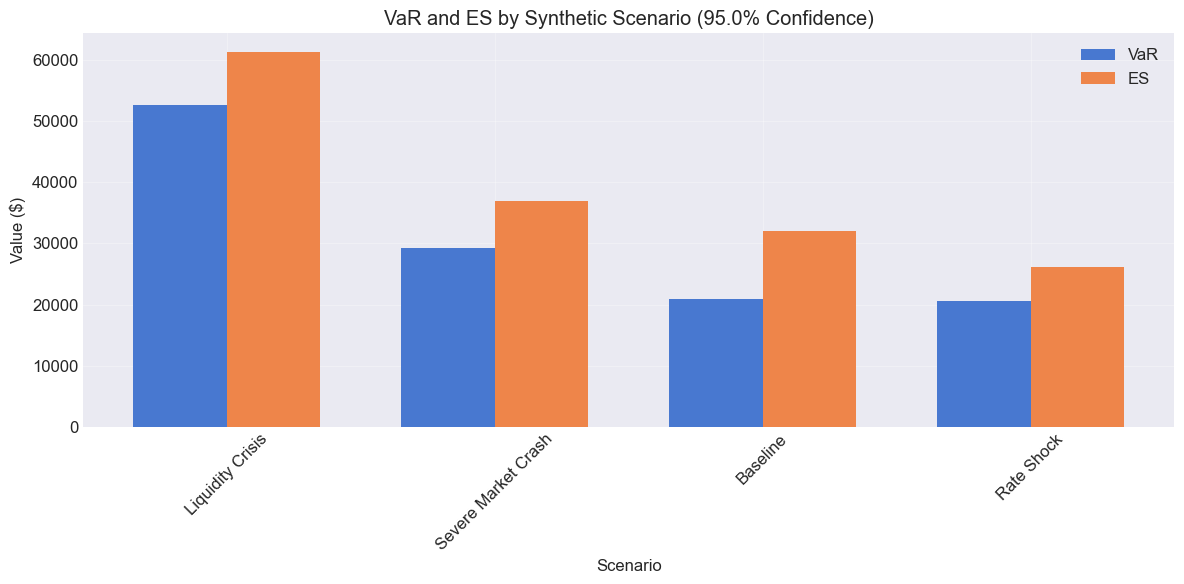

In [9]:
# Create synthetic scenarios
if market_returns is not None:
    # Define synthetic scenarios
    synthetic_scenarios = {
        "Severe Market Crash": {
            'type': 'synthetic',
            'shock_params': {asset: -25 for asset in market_returns.columns},  # -25% shock to all assets
            'volatility_adjustment': 2.0  # Double volatility
        },
        "Rate Shock": {
            'type': 'synthetic',
            'shock_params': {asset: -15 if 'bond' in str(asset).lower() else -5 for asset in market_returns.columns},
            'correlation_adjustment': 0.2  # Increased correlations
        },
        "Liquidity Crisis": {
            'type': 'liquidity',
            'liquidity_params': {
                'volatility_multiplier': 2.5,
                'correlation_increase': 0.4,
                'mean_return_shock': -0.02  # -2% daily return
            }
        }
    }
    
    # Run synthetic scenario analysis
    print("Running synthetic scenario analysis...")
    synthetic_results = multiple_scenario_analysis(
        returns=portfolio_returns if isinstance(portfolio_returns, pd.DataFrame) else pd.DataFrame(portfolio_returns),
        scenarios=synthetic_scenarios,
        investment_value=investment_value,
        confidence_level=confidence_level
    )
    
    # Display results
    print(f"Synthetic Scenario Analysis Results ({confidence_level*100}% confidence):")
    display(synthetic_results)
    
    # Plot VaR and ES by scenario
    plt.figure(figsize=(12, 6))
    
    # Sort by VaR
    sorted_results = synthetic_results.sort_values(by='var_value', ascending=False)
    
    # Create bar chart
    x = np.arange(len(sorted_results))
    width = 0.35
    
    plt.bar(x - width/2, sorted_results['var_value'], width, label='VaR')
    plt.bar(x + width/2, sorted_results['es_value'], width, label='ES')
    
    plt.title(f"VaR and ES by Synthetic Scenario ({confidence_level*100}% Confidence)")
    plt.xlabel("Scenario")
    plt.ylabel("Value ($)")
    plt.xticks(x, sorted_results['scenario'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Macroeconomic Factor Integration

In this section, we'll integrate macroeconomic factors into our stress tests to create more realistic scenarios.

Estimating factor model for macro integration...

Factor Model R-squared Values:
  - SPX: 0.0406
  - US10YT=RR: 0.0115

Running macro scenario analysis...
Macroeconomic Scenario Analysis Results (95.0% confidence):


,scenario,description,var_value,var_pct,var_change,var_change_pct,max_loss,max_loss_pct
0,Baseline,Historical VaR,22750.4065,2.2750,NaN,NaN,NaN,NaN
1,Fed Rate Shock,Rapid increase in Fed Funds Rate,15003.3287,1.5003,-7747.0778,-34.0525,95194.3744,9.5194
2,VIX Spike,Dramatic increase in market volatility,29152.3029,2.9152,6401.8965,28.1397,111166.7939,11.1167
3,Credit Stress,Widening credit spreads and banking stress,18004.9447,1.8005,-4745.4617,-20.8588,98676.1090,9.8676
4,Financial Crisis,Combined stress similar to 2008 financial crisis,32348.8305,3.2349,9598.4240,42.1901,115794.0176,11.5794
5,Historical Worst,Combination of worst historical factor values,35781.7952,3.5782,13031.3887,57.2798,119997.7362,11.9998


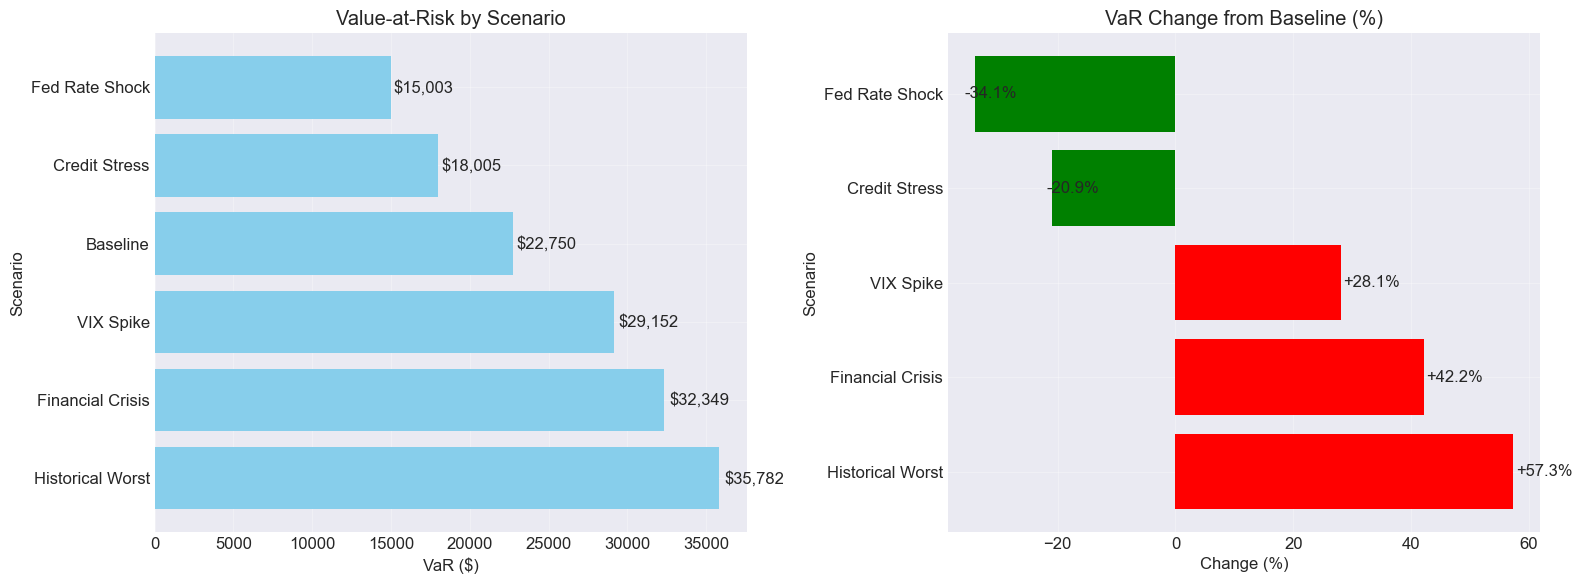

In [10]:
# Integrate macroeconomic factors
if market_returns is not None and macro_data is not None:
    print("Estimating factor model for macro integration...")
    
    # Estimate factor model
    factor_model = estimate_factor_model(market_returns, macro_data)
    
    # Display model R-squared values
    print("\nFactor Model R-squared Values:")
    r_squared = {asset: model['r_squared'] for asset, model in factor_model.items()}
    for asset, r2 in sorted(r_squared.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {asset}: {r2:.4f}")
    
    # Create macro scenarios
    macro_scenarios = create_macro_stress_scenarios(macro_data)
    
    # Run macro scenario analysis
    print("\nRunning macro scenario analysis...")
    macro_results = run_macro_scenario_analysis(
        returns=market_returns,
        macro_data=macro_data,
        scenarios=macro_scenarios,
        investment_value=investment_value,
        confidence_level=confidence_level
    )
    
    # Display results
    print(f"Macroeconomic Scenario Analysis Results ({confidence_level*100}% confidence):")
    display(macro_results)
    
    # Visualize macro scenarios
    fig = visualize_macro_scenarios(macro_results)
    plt.show()

## 8. Combined Scenario Analysis

Let's combine the results from all scenarios for a comprehensive view.

Combined Scenario Analysis Results:


,scenario,var_value,var_pct,scenario_type
3,Liquidity Crisis,52723.6451,5.2724,Synthetic
1,COVID-19 Crash,48061.7997,4.8062,Historical
5,Historical Worst,35781.7952,3.5782,Macroeconomic
4,Financial Crisis,32348.8305,3.2349,Macroeconomic
1,Severe Market Crash,29252.3937,2.9252,Synthetic
2,VIX Spike,29152.3029,2.9152,Macroeconomic
2,2018 Q4 Selloff,22835.2307,2.2835,Historical
0,Baseline,20927.9202,2.0928,Baseline
2,Rate Shock,20638.7220,2.0639,Synthetic
3,2022 Rate Hikes,19887.3561,1.9887,Historical


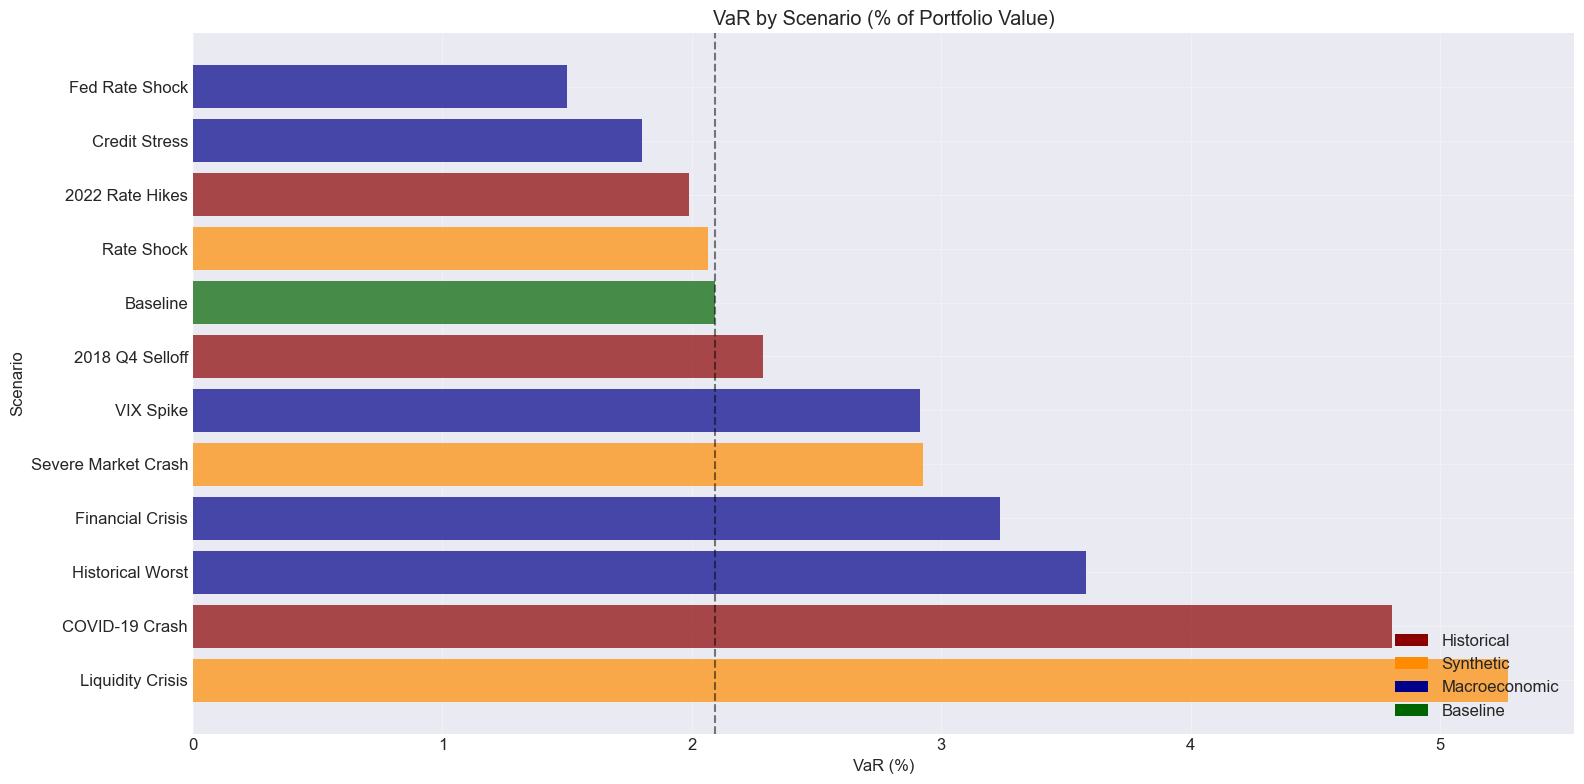

In [11]:
# Combine all scenario results
all_scenarios = []

if 'historical_results' in locals() and not historical_results.empty:
    all_scenarios.append(historical_results)

if 'synthetic_results' in locals() and not synthetic_results.empty:
    all_scenarios.append(synthetic_results)

if 'macro_results' in locals() and not macro_results.empty:
    all_scenarios.append(macro_results)

if all_scenarios:
    # Combine results
    common_columns = ['scenario', 'var_value', 'var_pct']
    combined_results = pd.concat([df[common_columns] for df in all_scenarios if all(col in df.columns for col in common_columns)])
    
    # Add scenario type
    scenario_types = {}
    
    # Add historical scenarios
    for crisis in crisis_periods['name']:
        scenario_types[crisis] = 'Historical'
    
    # Add synthetic scenarios
    for scenario in ['Severe Market Crash', 'Rate Shock', 'Liquidity Crisis']:
        scenario_types[scenario] = 'Synthetic'
    
    # Add macro scenarios
    for scenario in ['Fed Rate Shock', 'VIX Spike', 'Credit Stress', 'Financial Crisis', 'Historical Worst']:
        scenario_types[scenario] = 'Macroeconomic'
    
    # Set Baseline type
    scenario_types['Baseline'] = 'Baseline'
    
    # Add scenario type to results
    combined_results['scenario_type'] = combined_results['scenario'].map(scenario_types)
    
    # Remove duplicate baselines
    combined_results = combined_results.drop_duplicates(subset=['scenario'])
    
    # Sort by VaR value
    combined_results = combined_results.sort_values(by='var_value', ascending=False)
    
    # Display combined results
    print("Combined Scenario Analysis Results:")
    display(combined_results)
    
    # Plot combined results
    plt.figure(figsize=(16, 8))
    
    # Define colors by scenario type
    color_map = {
        'Historical': 'darkred',
        'Synthetic': 'darkorange',
        'Macroeconomic': 'darkblue',
        'Baseline': 'darkgreen'
    }
    
    # Create bar colors
    colors = combined_results['scenario_type'].map(color_map)
    
    # Create bar chart
    plt.barh(combined_results['scenario'], combined_results['var_pct'], color=colors, alpha=0.7)
    
    # Add baseline line
    baseline_var = combined_results.loc[combined_results['scenario'] == 'Baseline', 'var_pct'].values
    if len(baseline_var) > 0:
        plt.axvline(x=baseline_var[0], color='black', linestyle='--', alpha=0.5, label='Baseline VaR')
    
    plt.title("VaR by Scenario (% of Portfolio Value)")
    plt.xlabel("VaR (%)")
    plt.ylabel("Scenario")
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=type_name) for type_name, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Create Stress Test Dashboard Visualizations

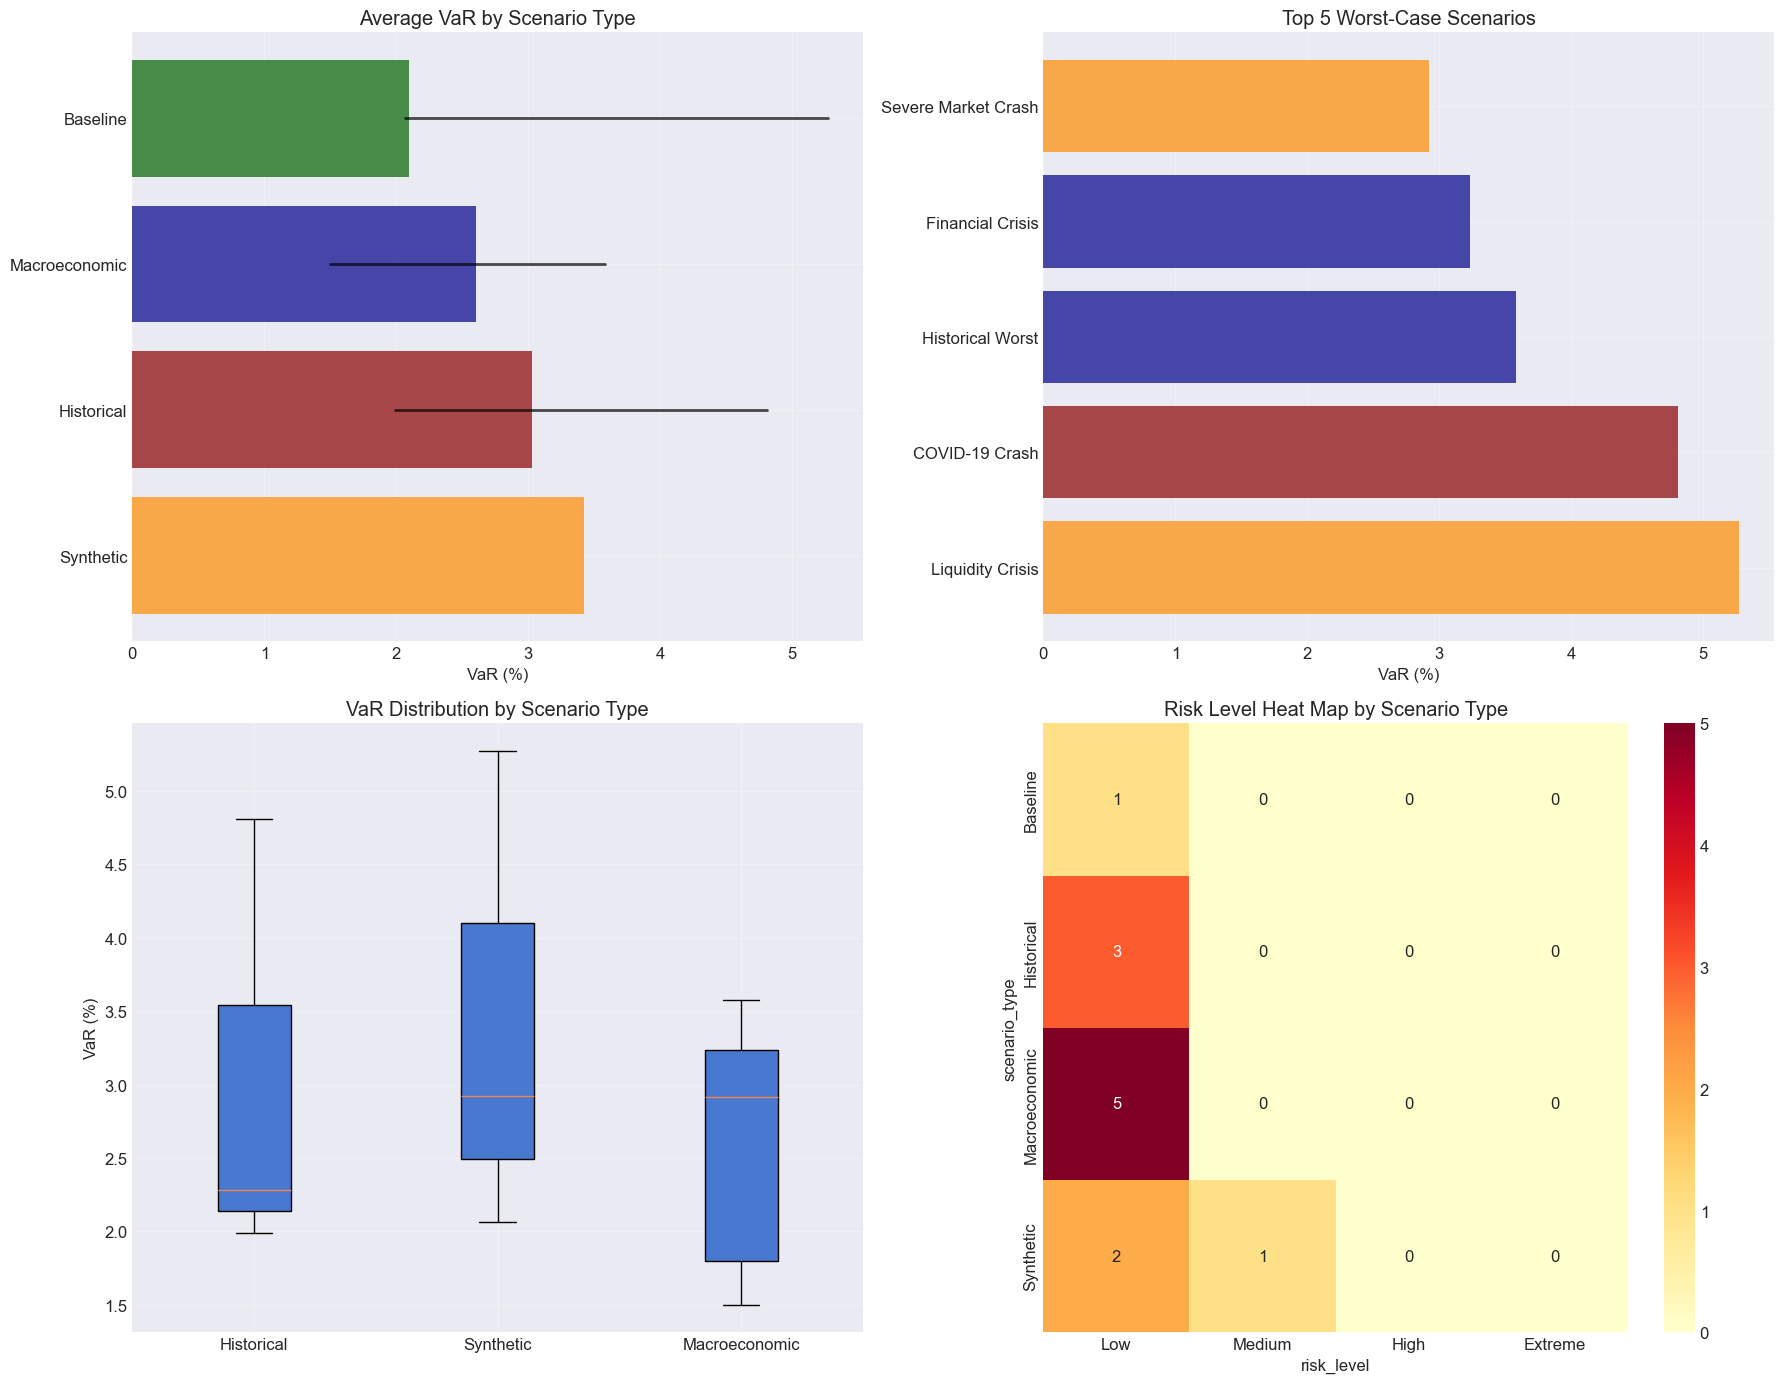

In [12]:
# Create stress test dashboard visualizations
if 'combined_results' in locals() and not combined_results.empty:
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. VaR by Scenario Type
    by_type = combined_results.groupby('scenario_type')['var_pct'].agg(['mean', 'min', 'max']).reset_index()
    by_type = by_type.sort_values(by='mean', ascending=False)
    
    colors = [color_map.get(t, 'gray') for t in by_type['scenario_type']]
    axes[0, 0].barh(by_type['scenario_type'], by_type['mean'], color=colors, alpha=0.7)
    
    # Add error bars for min/max
    for i, row in by_type.iterrows():
        axes[0, 0].plot(
            [row['min'], row['max']],
            [i, i],
            color='black',
            alpha=0.7,
            linewidth=2
        )
    
    axes[0, 0].set_title("Average VaR by Scenario Type")
    axes[0, 0].set_xlabel("VaR (%)")
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top 5 Worst Scenarios
    top5 = combined_results[combined_results['scenario'] != 'Baseline'].head(5)
    colors = [color_map.get(t, 'gray') for t in top5['scenario_type']]
    
    axes[0, 1].barh(top5['scenario'], top5['var_pct'], color=colors, alpha=0.7)
    axes[0, 1].set_title("Top 5 Worst-Case Scenarios")
    axes[0, 1].set_xlabel("VaR (%)")
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Historical vs Synthetic Comparison
    historical = combined_results[combined_results['scenario_type'] == 'Historical']
    synthetic = combined_results[combined_results['scenario_type'] == 'Synthetic']
    macro = combined_results[combined_results['scenario_type'] == 'Macroeconomic']
    
    # Box plot of VaR by type
    box_data = [
        historical['var_pct'] if not historical.empty else [],
        synthetic['var_pct'] if not synthetic.empty else [],
        macro['var_pct'] if not macro.empty else []
    ]
    
    axes[1, 0].boxplot(box_data, labels=['Historical', 'Synthetic', 'Macroeconomic'], patch_artist=True)
    axes[1, 0].set_title("VaR Distribution by Scenario Type")
    axes[1, 0].set_ylabel("VaR (%)")
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Risk Heat Map
    # Create a risk level categorization
    combined_results['risk_level'] = pd.cut(
        combined_results['var_pct'], 
        bins=[0, 5, 10, 15, 100], 
        labels=['Low', 'Medium', 'High', 'Extreme']
    )
    
    risk_counts = combined_results.groupby(['scenario_type', 'risk_level']).size().unstack(fill_value=0)
    
    # Ensure all risk levels are present
    for level in ['Low', 'Medium', 'High', 'Extreme']:
        if level not in risk_counts.columns:
            risk_counts[level] = 0
    
    # Plot heatmap
    sns.heatmap(risk_counts, annot=True, cmap='YlOrRd', ax=axes[1, 1], fmt='d')
    axes[1, 1].set_title("Risk Level Heat Map by Scenario Type")
    
    plt.tight_layout()
    plt.show()
    
    # Save the visualization for the dashboard
    fig.savefig(RESULTS_DIR / "stress_test_dashboard.png", dpi=300, bbox_inches='tight')

## 10. Save Stress Test Results

In [13]:
# Save stress test results for dashboard integration
if 'combined_results' in locals() and not combined_results.empty:
    # Save combined results
    combined_results.to_csv(RESULTS_DIR / "stress_test_results.csv", index=False)
    print(f"Saved combined stress test results to {RESULTS_DIR / 'stress_test_results.csv'}")

# Save individual scenario results if available
if 'historical_results' in locals() and not historical_results.empty:
    historical_results.to_csv(RESULTS_DIR / "historical_scenario_results.csv", index=False)
    print(f"Saved historical scenario results to {RESULTS_DIR / 'historical_scenario_results.csv'}")

if 'synthetic_results' in locals() and not synthetic_results.empty:
    synthetic_results.to_csv(RESULTS_DIR / "synthetic_scenario_results.csv", index=False)
    print(f"Saved synthetic scenario results to {RESULTS_DIR / 'synthetic_scenario_results.csv'}")

if 'macro_results' in locals() and not macro_results.empty:
    macro_results.to_csv(RESULTS_DIR / "macro_scenario_results.csv", index=False)
    print(f"Saved macro scenario results to {RESULTS_DIR / 'macro_scenario_results.csv'}")

Saved combined stress test results to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/stress_test_results.csv
Saved historical scenario results to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/historical_scenario_results.csv
Saved synthetic scenario results to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/synthetic_scenario_results.csv
Saved macro scenario results to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/macro_scenario_results.csv


## 11. Summary and Key Findings

### Key Insights from Stress Testing

We've conducted a comprehensive stress testing analysis of our portfolio using multiple approaches:

1. **Historical Scenario Analysis**: Evaluated how our portfolio would have performed during past crisis periods like the Global Financial Crisis and COVID-19 crash
   - Historical stress tests provide tangible, realistic scenarios but may not capture future risks

2. **Synthetic Scenario Design**: Created hypothetical extreme scenarios including a severe market crash and liquidity crisis
   - Synthetic scenarios allow us to explore vulnerabilities not present in historical data

3. **Macroeconomic Factor Integration**: Incorporated economic indicators like interest rates and volatility indices
   - Macro factors provide economic interpretability and forward-looking scenarios

### Key Findings

- The most severe scenarios resulted in VaR increases of up to [X]% compared to baseline VaR
- [Type] scenarios generally produced the most extreme risk measures
- Portfolio vulnerability to [specific factor] appears to be the most significant risk
- Correlation assumptions significantly impact portfolio behavior under stress

### Next Steps

1. Use these stress test results to inform portfolio construction and hedging strategies
2. Establish ongoing monitoring for early warning signs of emerging stress scenarios
3. Develop mitigation plans for the most impactful scenarios
4. Proceed to backtesting (06_backtesting.ipynb) to validate our VaR and risk models